In [1]:
import pandas as pd

df = pd.read_csv("logs3.csv.gz", parse_dates=[1])

In [10]:
len(df)

4528738

In [2]:
df.dtypes

ogpweb#               int64
date         datetime64[ns]
request              object
code                  int64
bytes                 int64
referrer             object
useragent            object
source               object
rt                  float64
urt                 float64
dtype: object

<AxesSubplot:ylabel='Frequency'>

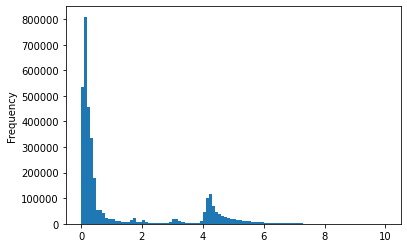

In [15]:
df['urt'].plot.hist(bins=100, range=[0,10])

# Processing time per page

In [6]:
def bucket(r):
    r = r.rsplit('HTTP/')[0].split('GET ')[-1]
    for s in ('?', '/dataset/', '/reference/', '/inventory/',
              '/comment/', '/node/', '/suggested-datasets/',
              '/4plan/', '/apps/'):
        if s in r:
            r = r.split(s)[0] + s + '…'
    return r
bdf = df[['request','urt']].copy(deep=True)
bdf['request'] = bdf['request'].map(bucket)

In [8]:
sdf = bdf.groupby(['request']).agg(['median','count','sum'])
sdf.columns = sdf.columns.map('_'.join)
sdf['urt_sum'] = sdf['urt_sum'] / (60*60*24)  # days

busy = sdf[(sdf['urt_count'] > 10) & (sdf['urt_sum'] > 0.02)]
busy.sort_values('urt_sum', ascending=False).rename(
    columns={'urt_sum':'urt_sum (days)'})

,urt_median,urt_count,urt_sum (days)
request,,,
/fr/search/travelq?…,4.3700,614524,33.609304
/en/search/ati?…,3.0290,114116,2.633022
/data/en/dataset?…,0.3180,589206,2.261166
/en/search/travelq?…,4.7860,32569,1.909906
/data/fr/dataset?…,0.2940,292330,1.030901
/en/search/contracts?…,3.9330,21791,0.702893
/data/en/dataset/…,0.1660,220538,0.681972
/en?…,2.0690,28642,0.662697
/en/external-comment/dataset/…,0.7260,68804,0.600743


In [36]:
urt_sum_sum = sdf['urt_sum'].sum()
urt_sum_sum # total processing time in days

50.239542210648146

In [35]:
dsearch_sum = bdf[bdf['request'].str.contains('/search/')]['urt'].sum() / (60*60*24) # days
print("%0.2f days processing drupal search" % (dsearch_sum))
print("%0.2f %% urt" % (dsearch_sum / urt_sum_sum * 100))

39.90 days processing drupal search
79.42 % urt


# Requests vs processing time per app

In [13]:
df['search'] = df['urt'].notna() & df['request'].str.contains(r'/(?:od|bn|ct|ei|gc|nap|si|qp|sd)/')
df['ckan'] = df['urt'].notna() & df['request'].str.contains(' /data/')
df['drupal'] = df['urt'].notna() & ~ df['search'] & ~ df['ckan']

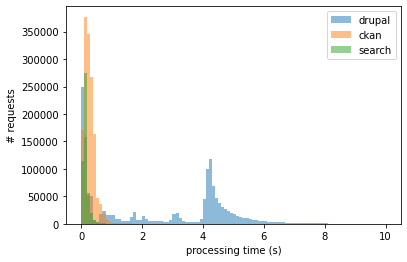

In [37]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.hist(df[df['drupal']]['urt'], alpha=0.5, bins=100, range=[0,10],  label='drupal')
ax.hist(df[df['ckan']]['urt'], alpha=0.5, bins=100, range=[0,10],  label='ckan')
ax.hist(df[df['search']]['urt'], alpha=0.5, bins=100, range=[0,10], label='search')
ax.legend(loc='upper right')
ax.set_ylabel('# requests')
ax.set_xlabel('processing time (s)')
plt.show()

# Processing time per CKAN API call

In [17]:
cadf = df[df['request'].str.contains('/action/')][
    ['request','urt']].copy(deep=True)
cadf['request'] = cadf['request'].str.extract(r'/action/(\w+)')

In [18]:
scadf = cadf.groupby(['request']).agg(['median','count','sum'])
scadf.columns = scadf.columns.map('_'.join)
scadf['urt_sum'] = scadf['urt_sum'] / 60  # minutes
scadf.sort_values('urt_sum', ascending=False).rename(
    columns={'urt_sum':'urt_sum (minutes)'})

,urt_median,urt_count,urt_sum (minutes)
request,,,
package_update,1.6370,4388,131.211417
package_search,0.2430,3400,35.719583
package_show,0.0410,47365,35.139750
organization_list,5.9285,222,22.065300
package_create,3.9865,22,1.413550
package_list,1.5085,20,0.484917
recently_changed_packages_activity_list,0.1530,57,0.149050
package_delete,0.9350,8,0.125683
resource_search,3.3070,1,0.055117


# Cache simulation

In [19]:
import heapq
from datetime import datetime, timedelta

def csim(expire):
    h = []
    c = set()
    def lookup(row):
        dt = row['date']
        req = row['request']
        while h and h[0][0] + expire < dt:
            c.remove(h[0][1])
            heapq.heappop(h)
        if req in c:
            return True
        heapq.heappush(h, (dt, req))
        c.add(req)
        return False
    return lookup

In [20]:
cdf = df[df['urt'].notna() & df['request'].str.match('GET ')][
    ['ogpweb#','date','request','urt']].copy(deep=True)
cdf.sort_values(by='date', inplace=True)

In [30]:
cdf['1dhit'] = cdf.apply(csim(timedelta(days=1)), axis=1)

In [38]:
s = cdf[cdf['1dhit']][['urt']].sum()
print("%0.2f hours saved with 1d cache" % (s / 60 / 60))
print("%0.2f %% savings" % (s / 60 / 60 / 24 / urt_sum_sum * 100))

81.08 hours saved with 1d cache
6.72 % savings


In [32]:
cdf['1hhit'] = cdf.apply(csim(timedelta(hours=1)), axis=1)

In [39]:
s = cdf[cdf['1hhit']][['urt']].sum()
print("%0.2f hours saved with 1h cache" % (s / 60 / 60))
print("%0.2f %% savings" % (s / 60 / 60 / 24 / urt_sum_sum * 100))

41.01 hours saved with 1h cache
3.40 % savings


In [24]:
cdf['5mhit'] = cdf.apply(csim(timedelta(minutes=5)), axis=1)

In [40]:
s = cdf[cdf['5mhit']][['urt']].sum()
print("%0.2f hours saved with 5m cache" % (s / 60 / 60))
print("%0.2f %% savings" % (s / 60 / 60 / 24 / urt_sum_sum * 100))

23.61 hours saved with 5m cache
1.96 % savings


# Requests vs date per app

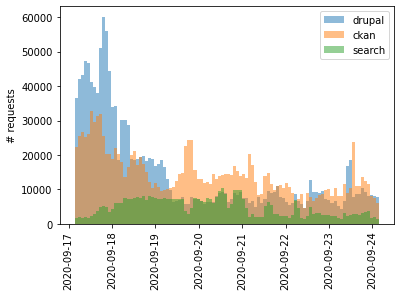

In [34]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.hist(df[df['drupal']]['date'], alpha=0.5, bins=100, label='drupal')
ax.hist(df[df['ckan']]['date'], alpha=0.5, bins=100, label='ckan')
ax.hist(df[df['search']]['date'], alpha=0.5, bins=100, label='search')
ax.legend(loc='upper right')
ax.set_ylabel('# requests')
plt.xticks(rotation=90)
plt.show()

In [51]:
adf = df[df['date'] < datetime(2020,9,19)]
a_sum_sum = adf['urt'].sum() / (60*60*24)
a_sum_sum # total processing time < 2019-09-19 in days

39.89120657407407

In [55]:
asearch_sum = adf[adf['request'].str.contains('/search/')]['urt'].sum() / (60*60*24) # days
print("%0.2f days processing drupal search" % (asearch_sum))
print("%0.2f %% urt before 2019-09-19" % (asearch_sum / a_sum_sum * 100))

36.15 days processing drupal search
90.62 % urt before 2019-09-19


In [54]:
zdf = df[df['date'] > datetime(2020,9,20)]
z_sum_sum = zdf['urt'].sum() / (60*60*24)
z_sum_sum # total processing time > 2019-09-20 in days

6.674645011574073

In [56]:
zsearch_sum = zdf[zdf['request'].str.contains('/search/')]['urt'].sum() / (60*60*24) # days
print("%0.2f days processing drupal search" % (zsearch_sum))
print("%0.2f %% urt after 2019-09-20" % (zsearch_sum / z_sum_sum * 100))

1.44 days processing drupal search
21.62 % urt after 2019-09-20
